In [15]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.stats.multitest import multipletests
import time

In [16]:
matplotlib.rcParams.update({'font.size': 12})

In [2]:
def calc_FDR_mz(q,mz, pre_dfs,p, datanames):
  dfs = []
  for dataname, df in pre_dfs.items():
    df["sig"] = ((df[p] <= q) | (df[p] >= 1 - q)) & ((df["mz"] <= -mz) | (df["mz"] >= mz))
    df["plus"] = df["mz"] > 0
#     df["sig_plus"] = df["sig"] & df["plus"]
#     df["sig_minus"] = df["sig"] & ~(df["plus"])
    df = df[df["n_cells_ont"] > 20].drop_duplicates("ontology_gene")
    dfs.append(df)
  merge_df = dfs[0].merge(dfs[1][["mz","ontology_gene",p,"sig","plus","n_cells_ont"]],on="ontology_gene",suffixes=["_" + x for x in datanames[:2]])
#   full_merge = merge_df
#   for dataname in datanames:
#     for s in ["plus","minus"]:
#       merge_df["num_" + s + "_" + dataname] = merge_df["geneR1A_uniq"].map(merge_df.groupby("geneR1A_uniq")["sig_plus_" + dataname].sum())
  num_sig_both_all = merge_df[merge_df["sig_" + datanames[0]] & merge_df["sig_" + datanames[1]] ].shape[0]
  num_sig_concord_all = merge_df[merge_df["sig_" + datanames[0]] & merge_df["sig_" + datanames[1]] & (merge_df["plus_" + datanames[1]] == merge_df["plus_" + datanames[0]])].shape[0]
  try:
    return min(1,2*(1 - num_sig_concord_all/num_sig_both_all))
  except:

    # happens when this is more extreme than everything shared between the datasets
    return 0

In [3]:
outpath = "output/HLCA_concordance/"

## HLCA Numbers

In [4]:
datanames = ["HLCA4_P2_10x_with_postprocessing_lung","HLCA4_P3_10x_with_postprocessing_lung"]
dfs = []
zdfs = []
for dataname in datanames:
  df = pd.read_parquet("../data/{}.pq".format(dataname),columns=["geneR1A_uniq","cell","cell_gene","numReads","tissue","compartment","free_annotation","called"])
  zdf = pd.read_parquet("../scripts/output/rijk_zscore/{}_sym_S_0.1_z_0.0_b_5.pq".format(dataname),columns=["geneR1A_uniq","cell","cell_gene","numReads","tissue","compartment","free_annotation"])

  df = df[df["called"] == 1]
  print(dataname,df["cell"].nunique(),df["numReads"].sum())
#   print(dataname,df["cell"].nunique())
  dfs.append(df)
  zdfs.append(zdf)

HLCA4_P2_10x_with_postprocessing_lung 28792 111206971
HLCA4_P3_10x_with_postprocessing_lung 24676 97428960


In [5]:
full_df = pd.concat(dfs,axis=0)
full_zdf = pd.concat(zdfs,axis=0)

In [6]:
# don't want counts skewed by unknown genes
full_df = full_df[~full_df["geneR1A_uniq"].str.startswith("unknown")]
full_zdf = full_zdf[~full_zdf["geneR1A_uniq"].str.startswith("unknown")]

In [7]:
full_zdf["num_genes_cell"] = full_zdf["cell"].map(full_zdf.groupby("cell")["geneR1A_uniq"].nunique())
full_zdf["num_reads_cell"] = full_zdf["cell"].map(full_zdf.groupby("cell")["numReads"].sum())

In [8]:
full_zdf["num_cells_gene"] = full_zdf["geneR1A_uniq"].map(full_zdf.groupby("geneR1A_uniq")["cell"].nunique())

In [9]:
full_zdf[full_zdf["num_cells_gene"] > 10]["geneR1A_uniq"].nunique()

1743

In [11]:
print("number of genes: {}".format(full_df["geneR1A_uniq"].nunique()))
print("number of cells: {}".format(full_df["cell"].nunique()))
print("number of freeanns: {}".format(full_df["free_annotation"].nunique()))

number of genes: 20153
number of cells: 53468
number of freeanns: 55


In [12]:
full_df["num_genes_cell"] = full_df["cell"].map(full_df.groupby("cell")["geneR1A_uniq"].nunique())
full_df["num_reads_cell"] = full_df["cell"].map(full_df.groupby("cell")["numReads"].sum())

/home/users/jolivier/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/users/jolivier/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [13]:
full_df.drop_duplicates("cell")["num_genes_cell"].median()

506.0

In [23]:
full_zdf.drop_duplicates("cell")["num_genes_cell"].median()

67.0

In [14]:
full_df.drop_duplicates("cell")["num_genes_cell"].mean()

659.368669110496

In [15]:
full_df.drop_duplicates("cell")["num_reads_cell"].median()

1883.5

In [16]:
full_df.drop_duplicates("cell")["num_reads_cell"].mean()

3863.5258846412808

In [17]:
full_df["num_cells_freeann"] = full_df["free_annotation"].map(full_df.groupby("free_annotation")["cell"].nunique())

/home/users/jolivier/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [171]:
full_df["num_reads_freeann"] = full_df["free_annotation"].map(full_df.groupby("free_annotation")["numReads"].sum())

In [172]:
full_df.drop_duplicates("free_annotation").sort_values("num_cells_freeann",ascending=False)

,called,cell,compartment,free_annotation,geneR1A_uniq,numReads,num_genes_cell,num_reads_cell,tissue,num_cells_freeann,num_reads_freeann
71,1,P2_8_S8_L00_CCCAGTTAGAAGATTC,immune,Macrophage,ABCC2,1,1165,7352,lung,11566,96395700
46,1,P2_2_S2_L00_CGCTTCAAGAGGACGG,endothelial,Capillary,ABCC2,1,357,924,lung,6819,6060041
50,1,P2_2_S2_L00_CAGCATAGTTACGCGC,endothelial,Capillary Aerocyte,ABCC2,1,737,1950,lung,4052,4218073
47,1,P2_5_S5_L00_AGCGGTCGTACACCGC,immune,Natural Killer,ABCC2,1,276,743,lung,3889,4865139
168,1,P2_8_S8_L00_CGCTTCATCTTGAGGT,epithelial,Alveolar Epithelial Type 2,ABI1,1,623,4484,lung,3320,19910247
52,1,P2_2_S2_L00_TACACGACAGGAACGT,immune,CD4+ Memory/Effector T,ABCC2,1,548,3817,lung,2406,4611081
345,1,P2_5_S5_L00_GTTCATTAGGTACTCT,stromal,Pericyte,ABI1,1,453,961,lung,1534,1461811
195,1,P2_7_S7_L00_TTTCCTCGTCTCTCTG,endothelial,Artery,ABI1,1,812,3296,lung,1276,2927878
117,1,P2_4_S4_L00_GTATCTTTCTCTTGAT,stromal,Alveolar Fibroblast,ABCC2,1,742,2632,lung,1251,1318838
70,1,P2_8_S8_L00_CAGATCAAGATGCCAG,epithelial,Ciliated,ABCC2,1,2151,14568,lung,1235,5659119


In [173]:
full_df.drop_duplicates("free_annotation").sort_values("num_reads_freeann",ascending=False)

,called,cell,compartment,free_annotation,geneR1A_uniq,numReads,num_genes_cell,num_reads_cell,tissue,num_cells_freeann,num_reads_freeann
71,1,P2_8_S8_L00_CCCAGTTAGAAGATTC,immune,Macrophage,ABCC2,1,1165,7352,lung,11566,96395700
168,1,P2_8_S8_L00_CGCTTCATCTTGAGGT,epithelial,Alveolar Epithelial Type 2,ABI1,1,623,4484,lung,3320,19910247
225,1,P2_1_S1_L00_CCGTGGACAGCGTAAG,epithelial,Mucous,ABI1,1,1414,15787,lung,491,10784008
46,1,P2_2_S2_L00_CGCTTCAAGAGGACGG,endothelial,Capillary,ABCC2,1,357,924,lung,6819,6060041
70,1,P2_8_S8_L00_CAGATCAAGATGCCAG,epithelial,Ciliated,ABCC2,1,2151,14568,lung,1235,5659119
47,1,P2_5_S5_L00_AGCGGTCGTACACCGC,immune,Natural Killer,ABCC2,1,276,743,lung,3889,4865139
52,1,P2_2_S2_L00_TACACGACAGGAACGT,immune,CD4+ Memory/Effector T,ABCC2,1,548,3817,lung,2406,4611081
50,1,P2_2_S2_L00_CAGCATAGTTACGCGC,endothelial,Capillary Aerocyte,ABCC2,1,737,1950,lung,4052,4218073
1294,1,P2_1_S1_L00_CTCAGAACATCGTCGG,epithelial,Club,ABLIM1,1,1371,12763,lung,750,3345508
195,1,P2_7_S7_L00_TTTCCTCGTCTCTCTG,endothelial,Artery,ABI1,1,812,3296,lung,1276,2927878


## MZ concordance

In [4]:
kind = "mz"
datanames = ["HLCA4_P2_10x_with_postprocessing_lung","HLCA4_P3_10x_with_postprocessing_lung"]
df1 = pd.read_csv("../scripts/output/final_FDRs_mz/{}_FDR_S_0.1_z_0.0_b_5.tsv".format(datanames[0]),sep="\t")
df2 = pd.read_csv("../scripts/output/final_FDRs_mz/{}_FDR_S_0.1_z_0.0_b_5.tsv".format(datanames[1]),sep="\t")

In [5]:
df1["ontology_gene"] = df1["ontology"] + df1["geneR1A_uniq"]
df2["ontology_gene"] = df2["ontology"] + df2["geneR1A_uniq"]

In [6]:
FDR_col = "FDR_HLCA4_P2_10x_with_postprocessing_lung_HLCA4_P3_10x_with_postprocessing_lung"
merged = df1.merge(df2[["ontology_gene","pval_adj","mz",FDR_col]],on="ontology_gene",suffixes = ["_P2","_P3"])

In [7]:
# merged["rev"] = 1 - merged["allp_P2"]
# merged["p_P2"] = merged[["rev","allp_P2"]].min(axis=1)
# merged["rev"] = 1 - merged["allp_P3"]
# merged["p_P3"] = merged[["rev","allp_P3"]].min(axis=1)
merged["abs_mz_P2"] = abs(merged["mz_P2"])
merged["abs_mz_P3"] = abs(merged["mz_P3"])
merged["max_p"] = merged[["pval_adj_P2","pval_adj_P3"]].max(axis=1)
merged["min_mz"] = merged[["abs_mz_P2","abs_mz_P3"]].min(axis=1)

In [22]:
merged[merged["geneR1A_uniq"] == "TPM1"]

,geneR1A_uniq,tissue,compartment,free_annotation,ontology,allp,mz_P2,pval_adj_P2,FDR_HLCA4_P2_10x_with_postprocessing_lung_HLCA4_P3_10x_with_postprocessing_lung_P2,ontology_gene,pval_adj_P3,mz_P3,FDR_HLCA4_P2_10x_with_postprocessing_lung_HLCA4_P3_10x_with_postprocessing_lung_P3,abs_mz_P2,abs_mz_P3,max_p,min_mz
5009,TPM1,lung,stromal,Airway Smooth Muscle,lungstromalAirway Smooth Muscle,0.030626,-0.355767,0.422857,0.0,lungstromalAirway Smooth MuscleTPM1,0.000749,-0.625727,0.0,0.355767,0.625727,0.422857,0.355767


In [56]:
es = 0.3
eps = 0.05
sub = merged[(merged["max_p"] < eps) & (merged["min_mz"] > es)]
sub["concord"] = sub["mz_P2"] * sub["mz_P3"] > 0
display(sub["concord"].value_counts())
display(sub["ontology"].value_counts().head())
display(sub["geneR1A_uniq"].value_counts())
print("num_pairs",sub.shape[0],"num_genes",sub["geneR1A_uniq"].nunique(), "num ontologies",sub["ontology"].nunique())
sub

/home/users/jolivier/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


True    40
Name: concord, dtype: int64

lungimmuneMacrophage                        9
lungepithelialAlveolar Epithelial Type 2    3
lungimmuneNatural Killer                    2
lungepithelialAlveolar Epithelial Type 1    2
lungepithelialCiliated                      2
Name: ontology, dtype: int64

MYL6          18
RPS24          7
LMNA           3
NEDD8-MDP1     1
CNPY2          1
CMC1           1
NUDT22         1
FAM50A         1
CRNDE          1
ALG5           1
SCGB1A1        1
TBXAS1         1
CD47           1
SHARPIN        1
LMO7           1
Name: geneR1A_uniq, dtype: int64

num_pairs 40 num_genes 15 num ontologies 23


,geneR1A_uniq,tissue,compartment,free_annotation,ontology,allp,mz_P2,pval_adj_P2,FDR_HLCA4_P2_10x_with_postprocessing_lung_HLCA4_P3_10x_with_postprocessing_lung_P2,ontology_gene,pval_adj_P3,mz_P3,FDR_HLCA4_P2_10x_with_postprocessing_lung_HLCA4_P3_10x_with_postprocessing_lung_P3,abs_mz_P2,abs_mz_P3,max_p,min_mz,concord
50,ALG5,lung,immune,Macrophage,lungimmuneMacrophage,4.511337e-05,-0.346337,2.453388e-03,0.0,lungimmuneMacrophageALG5,2.710869e-03,-0.338198,0.0,0.346337,0.338198,2.710869e-03,0.338198,True
367,CD47,lung,epithelial,Alveolar Epithelial Type 2,lungepithelialAlveolar Epithelial Type 2,8.564994e-04,-0.469269,2.902215e-02,0.0,lungepithelialAlveolar Epithelial Type 2CD47,8.213013e-16,-0.773993,0.0,0.469269,0.773993,2.902215e-02,0.469269,True
471,CMC1,lung,immune,Macrophage,lungimmuneMacrophage,9.998216e-01,0.303433,7.741818e-03,0.0,lungimmuneMacrophageCMC1,1.642588e-03,0.505557,0.0,0.303433,0.505557,7.741818e-03,0.303433,True
475,CNPY2,lung,immune,Macrophage,lungimmuneMacrophage,9.999846e-01,0.809776,9.393672e-04,0.0,lungimmuneMacrophageCNPY2,2.218064e-02,0.440315,0.0,0.809776,0.440315,2.218064e-02,0.440315,True
618,CRNDE,lung,epithelial,Ciliated,lungepithelialCiliated,1.688886e-11,-0.604122,2.220759e-09,0.0,lungepithelialCiliatedCRNDE,3.876890e-04,-0.680301,0.0,0.604122,0.680301,3.876890e-04,0.604122,True
989,FAM50A,lung,immune,Macrophage,lungimmuneMacrophage,1.000000e+00,0.365289,2.110131e-09,0.0,lungimmuneMacrophageFAM50A,9.381642e-10,0.390193,0.0,0.365289,0.390193,2.110131e-09,0.365289,True
1524,LMNA,lung,epithelial,Alveolar Epithelial Type 2,lungepithelialAlveolar Epithelial Type 2,2.700216e-07,-0.489229,2.050768e-05,0.0,lungepithelialAlveolar Epithelial Type 2LMNA,1.951078e-13,-0.373861,0.0,0.489229,0.373861,2.050768e-05,0.373861,True
1526,LMNA,lung,epithelial,Mucous,lungepithelialMucous,2.841548e-05,-0.468581,1.615099e-03,0.0,lungepithelialMucousLMNA,7.378637e-03,-0.629400,0.0,0.468581,0.629400,7.378637e-03,0.468581,True
1533,LMNA,lung,stromal,Adventitial Fibroblast,lungstromalAdventitial Fibroblast,3.015252e-04,-0.694493,1.218549e-02,0.0,lungstromalAdventitial FibroblastLMNA,1.144645e-08,-0.512826,0.0,0.694493,0.512826,1.218549e-02,0.512826,True
1536,LMO7,lung,epithelial,Alveolar Epithelial Type 1,lungepithelialAlveolar Epithelial Type 1,8.666139e-06,-0.586774,5.453477e-04,0.0,lungepithelialAlveolar Epithelial Type 1LMO7,1.342910e-02,-0.497265,0.0,0.586774,0.497265,1.342910e-02,0.497265,True


In [25]:
ind = "P2"
if ind == "P2":
  df = df1
elif ind == "P3":
  df = df2
df["abs_mz"] = abs(df["mz"])
# df["rev"] = 1 - df["allp"]

# df["p"] = df[["rev","allp"]].min(axis=1)
sub = df[(df["abs_mz"] > es) & (df["pval_adj"] < eps)]
# sub["concord"] = sub["mz_P2"] * sub["mz_P3"] > 0
# display(sub["concord"].value_counts())
display(sub["ontology"].value_counts().head())
display(sub["geneR1A_uniq"].value_counts().head(30))
print("num_pairs",sub.shape[0],"num_genes",sub["geneR1A_uniq"].nunique(),"num ontologies",sub["ontology"].nunique())
sub

lungimmuneMacrophage                        29
lungepithelialCiliated                       7
lungendothelialCapillary                     7
lungepithelialAlveolar Epithelial Type 2     6
lungendothelialArtery                        5
Name: ontology, dtype: int64

MYL6          21
SCGB1A1        8
RPS24          8
LMNA           7
ATP5F1C        6
SOD2           3
CHCHD2         2
CD47           2
RPL29          2
MMP7           1
SHARPIN        1
LMO7           1
NUDT22         1
MCUB           1
CRNDE          1
CARD19         1
EFCAB1         1
FAM50A         1
CNPY2          1
BOLA3          1
CYBB           1
TBXAS1         1
STX4           1
MORF4L1        1
ZNF706         1
CMC1           1
MAGOH          1
RPL17          1
NEDD8-MDP1     1
RBIS           1
Name: geneR1A_uniq, dtype: int64

num_pairs 101 num_genes 51 num ontologies 28


,geneR1A_uniq,tissue,compartment,free_annotation,ontology,allp,mz,pval_adj,FDR_HLCA4_P2_10x_with_postprocessing_lung_HLCA4_P3_10x_with_postprocessing_lung,ontology_gene,abs_mz
86,ALG5,lung,immune,Macrophage,lungimmuneMacrophage,4.511337e-05,-0.346337,2.453388e-03,0.0,lungimmuneMacrophageALG5,0.346337
91,ANAPC11,lung,immune,Macrophage,lungimmuneMacrophage,9.999731e-01,0.324097,1.539038e-03,0.0,lungimmuneMacrophageANAPC11,0.324097
173,ARHGAP18,lung,endothelial,Capillary,lungendothelialCapillary,3.824666e-04,-0.384830,1.490943e-02,0.0,lungendothelialCapillaryARHGAP18,0.384830
316,ATP5F1C,lung,endothelial,Artery,lungendothelialArtery,1.000000e+00,1.356214,5.004266e-13,0.0,lungendothelialArteryATP5F1C,1.356214
317,ATP5F1C,lung,endothelial,Capillary,lungendothelialCapillary,1.000000e+00,1.497271,0.000000e+00,0.0,lungendothelialCapillaryATP5F1C,1.497271
...,...,...,...,...,...,...,...,...,...,...,...
8041,TBXAS1,lung,immune,Macrophage,lungimmuneMacrophage,2.415112e-09,-0.519667,2.263525e-07,0.0,lungimmuneMacrophageTBXAS1,0.519667
8067,THYN1,lung,epithelial,Ciliated,lungepithelialCiliated,6.013525e-04,-0.891720,2.153624e-02,0.0,lungepithelialCiliatedTHYN1,0.891720
8716,XRN2,lung,immune,Macrophage,lungimmuneMacrophage,3.221514e-05,-0.367512,1.796300e-03,0.0,lungimmuneMacrophageXRN2,0.367512
8774,ZNF706,lung,immune,Macrophage,lungimmuneMacrophage,1.535320e-25,-0.319566,4.830776e-23,0.0,lungimmuneMacrophageZNF706,0.319566


In [181]:
thresh = 0.025
sub = merged[(merged[FDR_col + "_P2"] < thresh) & (merged[FDR_col + "_P2"] < thresh)]
sub["concord"] = sub["mz_P2"] * sub["mz_P3"] > 0
display(sub["concord"].value_counts())
display(sub["ontology"].value_counts().head())
print("num_pairs",sub.shape[0],"num_genes",sub["geneR1A_uniq"].nunique())
sub

/home/users/jolivier/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


True     522
False     60
Name: concord, dtype: int64

lungimmuneMacrophage                        220
lungepithelialAlveolar Epithelial Type 2     31
lungepithelialCiliated                       31
lungendothelialCapillary Aerocyte            26
lungimmuneProliferating Macrophage           24
Name: ontology, dtype: int64

num_pairs 582 num_genes 285


,geneR1A_uniq,tissue,compartment,free_annotation,ontology,allp_P2,mz_P2,FDR_HLCA4_P2_10x_with_postprocessing_lung_HLCA4_P3_10x_with_postprocessing_lung_P2,ontology_gene,allp_P3,mz_P3,FDR_HLCA4_P2_10x_with_postprocessing_lung_HLCA4_P3_10x_with_postprocessing_lung_P3,rev,p_P2,p_P3,abs_mz_P2,abs_mz_P3,max_p,min_mz,concord
4,ACAP2,lung,immune,Macrophage,lungimmuneMacrophage,9.018492e-01,0.317821,0.000000,lungimmuneMacrophageACAP2,0.439982,-0.034250,0.368591,0.560018,9.815084e-02,0.439982,0.317821,0.034250,0.439982,0.034250,False
7,ADIRF,lung,endothelial,Capillary Aerocyte,lungendothelialCapillary Aerocyte,2.359026e-10,-0.174266,0.000000,lungendothelialCapillary AerocyteADIRF,0.009708,-0.146826,0.041237,0.990292,2.359026e-10,0.009708,0.174266,0.146826,0.009708,0.146826,True
8,ADIRF,lung,endothelial,Lymphatic,lungendothelialLymphatic,2.008082e-02,-0.205096,0.000000,lungendothelialLymphaticADIRF,0.096211,-0.172994,0.073620,0.903789,2.008082e-02,0.096211,0.205096,0.172994,0.096211,0.172994,True
9,ADIRF,lung,endothelial,Vein,lungendothelialVein,2.486038e-03,-0.189338,0.000000,lungendothelialVeinADIRF,0.173909,-0.154822,0.102767,0.826091,2.486038e-03,0.173909,0.189338,0.154822,0.173909,0.154822,True
10,ADIRF,lung,epithelial,Alveolar Epithelial Type 1,lungepithelialAlveolar Epithelial Type 1,1.968219e-02,-0.200172,0.000000,lungepithelialAlveolar Epithelial Type 1ADIRF,0.002024,-0.218786,0.000000,0.997976,1.968219e-02,0.002024,0.200172,0.218786,0.019682,0.200172,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5270,YWHAB,lung,immune,Proliferating Macrophage,lungimmuneProliferating Macrophage,1.682698e-01,-0.222404,0.017857,lungimmuneProliferating MacrophageYWHAB,0.110463,-0.210395,0.017391,0.889537,1.682698e-01,0.110463,0.222404,0.210395,0.168270,0.210395,True
5286,ZNF706,lung,immune,Macrophage,lungimmuneMacrophage,1.535320e-25,-0.319566,0.000000,lungimmuneMacrophageZNF706,0.008332,-0.116061,0.056075,0.991668,1.535320e-25,0.008332,0.319566,0.116061,0.008332,0.116061,True
5287,ZNF706,lung,immune,Proliferating Macrophage,lungimmuneProliferating Macrophage,5.682998e-02,-0.319566,0.000000,lungimmuneProliferating MacrophageZNF706,0.317202,-0.116061,0.143885,0.682798,5.682998e-02,0.317202,0.319566,0.116061,0.317202,0.116061,True
5288,ZNHIT1,lung,immune,Macrophage,lungimmuneMacrophage,9.993535e-01,0.486581,0.000000,lungimmuneMacrophageZNHIT1,0.937193,0.263412,0.000000,0.062807,6.465113e-04,0.062807,0.486581,0.263412,0.062807,0.263412,True


In [188]:
df1["abs_mz"] = abs(df1["mz"])
df1[df1["ontology"] == "lungstromalAirway Smooth Muscle"].sort_values("abs_mz",ascending=False)

,geneR1A_uniq,tissue,compartment,free_annotation,ontology,allp,mz,FDR_HLCA4_P2_10x_with_postprocessing_lung_HLCA4_P3_10x_with_postprocessing_lung,ontology_gene,abs_mz
3254,MYL6,lung,stromal,Airway Smooth Muscle,lungstromalAirway Smooth Muscle,1.180403e-39,-1.059181,0.000000,lungstromalAirway Smooth MuscleMYL6,1.059181
2893,LMNA,lung,stromal,Airway Smooth Muscle,lungstromalAirway Smooth Muscle,5.516071e-03,-0.456577,0.000000,lungstromalAirway Smooth MuscleLMNA,0.456577
8289,TPM1,lung,stromal,Airway Smooth Muscle,lungstromalAirway Smooth Muscle,3.062565e-02,-0.355767,0.000000,lungstromalAirway Smooth MuscleTPM1,0.355767
496,ATP5PO,lung,stromal,Airway Smooth Muscle,lungstromalAirway Smooth Muscle,9.774245e-02,-0.330565,0.000000,lungstromalAirway Smooth MuscleATP5PO,0.330565
7840,SOD1,lung,stromal,Airway Smooth Muscle,lungstromalAirway Smooth Muscle,1.087599e-01,-0.328340,0.000000,lungstromalAirway Smooth MuscleSOD1,0.328340
...,...,...,...,...,...,...,...,...,...,...
5137,RPL21,lung,stromal,Airway Smooth Muscle,lungstromalAirway Smooth Muscle,5.362651e-01,0.001581,0.556422,lungstromalAirway Smooth MuscleRPL21,0.001581
6465,RPS15,lung,stromal,Airway Smooth Muscle,lungstromalAirway Smooth Muscle,5.188603e-01,-0.001066,0.587586,lungstromalAirway Smooth MuscleRPS15,0.001066
5630,RPL35,lung,stromal,Airway Smooth Muscle,lungstromalAirway Smooth Muscle,5.193608e-01,0.000904,0.587937,lungstromalAirway Smooth MuscleRPL35,0.000904
3156,MT1M,lung,stromal,Airway Smooth Muscle,lungstromalAirway Smooth Muscle,5.090585e-01,-0.000384,0.600975,lungstromalAirway Smooth MuscleMT1M,0.000384


In [189]:
df2["abs_mz"] = abs(df2["mz"])
df2[df2["ontology"] == "lungstromalAirway Smooth Muscle"].sort_values("abs_mz",ascending=False)

,geneR1A_uniq,tissue,compartment,free_annotation,ontology,allp,mz,FDR_HLCA4_P2_10x_with_postprocessing_lung_HLCA4_P3_10x_with_postprocessing_lung,ontology_gene,abs_mz,rev,p
346,ATP5F1C,lung,stromal,Airway Smooth Muscle,lungstromalAirway Smooth Muscle,1.000000e+00,1.563535,0.000000,lungstromalAirway Smooth MuscleATP5F1C,1.563535,5.551115e-16,5.551115e-16
3329,MYL6,lung,stromal,Airway Smooth Muscle,lungstromalAirway Smooth Muscle,1.502122e-31,-0.813713,0.000000,lungstromalAirway Smooth MuscleMYL6,0.813713,1.000000e+00,1.502122e-31
4197,PPP1R12A,lung,stromal,Airway Smooth Muscle,lungstromalAirway Smooth Muscle,1.746857e-06,-0.789436,0.000000,lungstromalAirway Smooth MusclePPP1R12A,0.789436,9.999983e-01,1.746857e-06
6192,RPL4,lung,stromal,Airway Smooth Muscle,lungstromalAirway Smooth Muscle,7.809723e-09,-0.760865,0.000000,lungstromalAirway Smooth MuscleRPL4,0.760865,1.000000e+00,7.809723e-09
8784,TPM1,lung,stromal,Airway Smooth Muscle,lungstromalAirway Smooth Muscle,1.335324e-05,-0.625727,0.000000,lungstromalAirway Smooth MuscleTPM1,0.625727,9.999866e-01,1.335324e-05
...,...,...,...,...,...,...,...,...,...,...,...,...
327,ATP5F1B,lung,stromal,Airway Smooth Muscle,lungstromalAirway Smooth Muscle,5.052535e-01,-0.002674,0.585376,lungstromalAirway Smooth MuscleATP5F1B,0.002674,4.947465e-01,4.947465e-01
6902,RPS15,lung,stromal,Airway Smooth Muscle,lungstromalAirway Smooth Muscle,5.158591e-01,-0.001854,0.588558,lungstromalAirway Smooth MuscleRPS15,0.001854,4.841409e-01,4.841409e-01
1194,COX6C,lung,stromal,Airway Smooth Muscle,lungstromalAirway Smooth Muscle,5.222608e-01,0.001284,0.580889,lungstromalAirway Smooth MuscleCOX6C,0.001284,4.777392e-01,4.777392e-01
1920,ELOB,lung,stromal,Airway Smooth Muscle,lungstromalAirway Smooth Muscle,5.128088e-01,-0.000887,0.598765,lungstromalAirway Smooth MuscleELOB,0.000887,4.871912e-01,4.871912e-01


In [190]:
df1[df1["geneR1A_uniq"] == "TPM1"]

,geneR1A_uniq,tissue,compartment,free_annotation,ontology,allp,mz,FDR_HLCA4_P2_10x_with_postprocessing_lung_HLCA4_P3_10x_with_postprocessing_lung,ontology_gene,abs_mz
8289,TPM1,lung,stromal,Airway Smooth Muscle,lungstromalAirway Smooth Muscle,0.030626,-0.355767,0.0,lungstromalAirway Smooth MuscleTPM1,0.355767


In [191]:
df2[df2["geneR1A_uniq"] == "TPM1"]

,geneR1A_uniq,tissue,compartment,free_annotation,ontology,allp,mz,FDR_HLCA4_P2_10x_with_postprocessing_lung_HLCA4_P3_10x_with_postprocessing_lung,ontology_gene,abs_mz,rev,p
8784,TPM1,lung,stromal,Airway Smooth Muscle,lungstromalAirway Smooth Muscle,0.000013,-0.625727,0.000000,lungstromalAirway Smooth MuscleTPM1,0.625727,0.999987,0.000013
8785,TPM1,lung,stromal,Vascular Smooth Muscle,lungstromalVascular Smooth Muscle,0.685281,0.115562,0.143113,lungstromalVascular Smooth MuscleTPM1,0.115562,0.314719,0.314719


## anova concordance

In [3]:
kind = "factor"
# kind = "split"
if kind == "factor":
  suff = "_factor"
elif kind == "split":
  suff = ""
weight = "_unweight"
# weight = ""
datanames = ["HLCA4_P2_10x_with_postprocessing_lung","HLCA4_P3_10x_with_postprocessing_lung"]
df1 = pd.read_csv("../scripts/output/final_FDRs_anova{}/{}_FDR{}_S_0.1_z_0.0_b_5.tsv".format(suff,datanames[0],weight),sep="\t")
df2 = pd.read_csv("../scripts/output/final_FDRs_anova{}/{}_FDR{}_S_0.1_z_0.0_b_5.tsv".format(suff,datanames[1],weight),sep="\t")

In [4]:
if kind == "split":
  df1["iden"] =  df1["gene"] + df1["variable"] + df1["bool"].astype(str)
  df2["iden"] =  df2["gene"] + df2["variable"] + df2["bool"].astype(str)
elif kind == "factor":
  df1["iden"] =  df1["gene"] + df1["variable"]
  df2["iden"] =  df2["gene"] + df2["variable"]
df1["abs_coeff"] = abs(df1["coeff"])
df2["abs_coeff"] = abs(df2["coeff"])

In [5]:
FDR_col = "FDR_HLCA4_P2_10x_with_postprocessing_lung_HLCA4_P3_10x_with_postprocessing_lung"
merged = df1.merge(df2[["iden","pval_adj","coeff","abs_coeff",FDR_col]],on="iden",suffixes = ["_P2","_P3"])

In [6]:
len(set(df1["gene"]).union(set(df2["gene"])))

403

In [7]:
merged["min_coeff"] = merged[["abs_coeff_P3","abs_coeff_P2"]].min(axis=1)
merged["max_sig"] = merged[["pval_adj_P2","pval_adj_P3"]].max(axis=1)

In [8]:
merged["gene"].nunique()

292

In [9]:
merged[merged["gene"] == "ATP5F1C"]

,gene,variable,sig,coeff_P2,gene_variable,FDR_HLCA4_P2_10x_with_postprocessing_lung_HLCA4_P3_10x_with_postprocessing_lung_P2,pval_adj_P2,iden,abs_coeff_P2,pval_adj_P3,coeff_P3,abs_coeff_P3,FDR_HLCA4_P2_10x_with_postprocessing_lung_HLCA4_P3_10x_with_postprocessing_lung_P3,min_coeff,max_sig
103,ATP5F1C,immune,1.533188e-07,0.060649,ATP5F1Cimmune,0.000000,5.379464e-07,ATP5F1Cimmune,0.060649,3.958098e-07,0.086266,0.086266,0.000000,0.060649,5.379464e-07
149,ATP5F1C,epithelial,1.533188e-07,0.039412,ATP5F1Cepithelial,0.066667,5.379464e-07,ATP5F1Cepithelial,0.039412,3.958098e-07,0.014807,0.014807,0.045455,0.014807,5.379464e-07


In [10]:
es = .3
eps = 0.05
sub = merged[(merged["max_sig"] < eps) & (merged["min_coeff"] > es)]
sub["concord"] = sub["coeff_P2"] * sub["coeff_P3"] > 0
display(sub["concord"].value_counts())
display(sub["variable"].value_counts().head())
display(sub["gene"].value_counts())
print("num_pairs",sub.shape[0],"num_genes",sub["gene"].nunique())
sub

/home/users/jolivier/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


True    4
Name: concord, dtype: int64

epithelial     2
stromal        1
endothelial    1
Name: variable, dtype: int64

MYL6     2
RPS24    1
CD47     1
Name: gene, dtype: int64

num_pairs 4 num_genes 3


,gene,variable,sig,coeff_P2,gene_variable,FDR_HLCA4_P2_10x_with_postprocessing_lung_HLCA4_P3_10x_with_postprocessing_lung_P2,pval_adj_P2,iden,abs_coeff_P2,pval_adj_P3,coeff_P3,abs_coeff_P3,FDR_HLCA4_P2_10x_with_postprocessing_lung_HLCA4_P3_10x_with_postprocessing_lung_P3,min_coeff,max_sig,concord
289,RPS24,epithelial,1.002202e-12,-1.040537,RPS24epithelial,0.309091,4.886845e-12,RPS24epithelial,1.040537,7.345243e-15,-0.989199,0.989199,0.333333,0.989199,4.886845e-12,True
400,MYL6,stromal,2.607357e-18,-1.136002,MYL6stromal,0.377778,1.458532e-17,MYL6stromal,1.136002,4.437732e-18,-1.154786,1.154786,0.395349,1.136002,1.458532e-17,True
401,MYL6,endothelial,2.607357e-18,-0.881765,MYL6endothelial,0.377778,1.458532e-17,MYL6endothelial,0.881765,4.437732e-18,-0.999644,0.999644,0.395349,0.881765,1.458532e-17,True
570,CD47,epithelial,2.942013e-03,-0.369142,CD47epithelial,0.464752,5.164190e-03,CD47epithelial,0.369142,4.146036e-04,-0.880989,0.880989,0.435986,0.369142,5.164190e-03,True


In [14]:
ind = "P3"
if ind == "P2":
  df = df1
elif ind == "P3":
  df = df2
es = .3
eps = 0.05
sub = df[(df["pval_adj"] < eps) & (df["abs_coeff"] > es)]
# sub["concord"] = sub["coeff"] * sub["coeff_P3"] > 0
# display(sub["concord"].value_counts())
display(sub["variable"].value_counts().head())
display(sub["gene"].value_counts())
print("num_pairs",sub.shape[0],"num_genes",sub["gene"].nunique())
sub

stromal        9
immune         4
epithelial     3
endothelial    1
Name: variable, dtype: int64

RPS24      2
MYL6       2
NUPR1      2
HNRNPDL    1
ITM2B      1
COX4I1     1
ANXA1      1
CD47       1
RPL4       1
EMP2       1
ATP5PO     1
SNHG8      1
SOD1       1
ATP5F1C    1
Name: gene, dtype: int64

num_pairs 17 num_genes 14


,gene,variable,sig,coeff,gene_variable,FDR_HLCA4_P2_10x_with_postprocessing_lung_HLCA4_P3_10x_with_postprocessing_lung,pval_adj,iden,abs_coeff
57,COX4I1,stromal,1.630338e-08,0.390608,COX4I1stromal,0.000000,5.632078e-08,COX4I1stromal,0.390608
96,NUPR1,stromal,4.038227e-03,0.446010,NUPR1stromal,0.000000,6.118526e-03,NUPR1stromal,0.446010
134,ATP5F1C,stromal,1.208261e-07,1.925450,ATP5F1Cstromal,0.000000,3.958098e-07,ATP5F1Cstromal,1.925450
144,RPS24,immune,1.414926e-15,0.521178,RPS24immune,0.000000,7.345243e-15,RPS24immune,0.521178
176,ANXA1,immune,6.464843e-05,0.338631,ANXA1immune,0.000000,1.340961e-04,ANXA1immune,0.338631
436,RPS24,epithelial,1.414926e-15,-0.989199,RPS24epithelial,0.333333,7.345243e-15,RPS24epithelial,0.989199
479,ATP5PO,stromal,3.100258e-06,-0.323743,ATP5POstromal,0.364583,8.091333e-06,ATP5POstromal,0.323743
543,MYL6,endothelial,8.034631e-19,-0.999644,MYL6endothelial,0.395349,4.437732e-18,MYL6endothelial,0.999644
544,MYL6,stromal,8.034631e-19,-1.154786,MYL6stromal,0.395349,4.437732e-18,MYL6stromal,1.154786
595,RPL4,stromal,3.712975e-33,-0.740443,RPL4stromal,0.422535,2.432639e-32,RPL4stromal,0.740443


In [104]:
merged[merged["gene"] == "ATP5F1C"]

,gene,variable,sig_P2,coeff_P2,gene_variable,FDR_HLCA4_P2_10x_with_postprocessing_lung_HLCA4_P3_10x_with_postprocessing_lung_P2,iden,abs_coeff_P2,sig_P3,coeff_P3,abs_coeff_P3,FDR_HLCA4_P2_10x_with_postprocessing_lung_HLCA4_P3_10x_with_postprocessing_lung_P3,min_coeff,max_sig
172,ATP5F1C,epithelial,2.890971e-07,0.034310,ATP5F1Cepithelial,0.160920,ATP5F1Cepithelial,0.034310,1.735620e-07,0.021190,0.021190,0.183486,0.021190,2.890971e-07
410,ATP5F1C,immune,2.890971e-07,-0.051295,ATP5F1Cimmune,0.371134,ATP5F1Cimmune,0.051295,1.735620e-07,0.000126,0.000126,0.371134,0.000126,2.890971e-07


## Concordance plotting

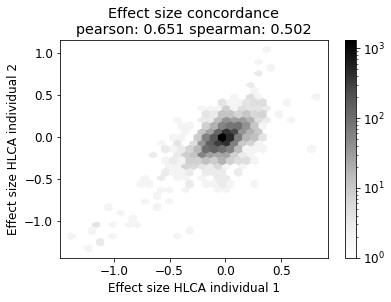

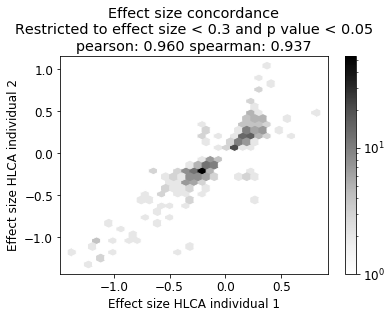

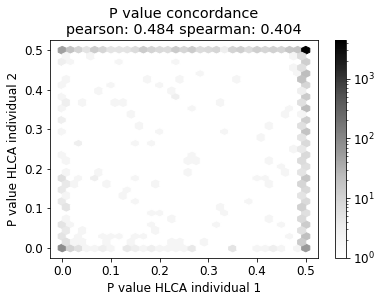

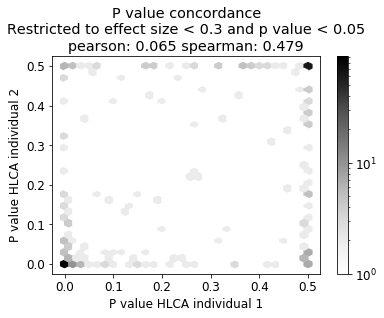

In [17]:
kind = "mz"
if kind == "mz":
  cols = ["mz","pval_adj"]
else:
  cols = ["sig","coeff",FDR_col]
eps = 0.05
es = 0.3
title_dict = {"mz" : "Effect size", "pval_adj" : "P value"}
name_dict = {x : "HLCA individual {}".format(i) for x, i in zip(["P2","P3"],range(1,3))}

for col in cols:
# for col in ["sig","coeff",FDR_col]:
  plt.hexbin(merged[col + "_P2"],merged[col + "_P3"],gridsize=30,cmap="Greys",bins="log")
  plt.xlabel("{} {}".format(title_dict[col],name_dict["P2"]))
  plt.ylabel("{} {}".format(title_dict[col],name_dict["P3"]))
  plt.colorbar()
  plt.title("{} concordance\npearson: {:.3f} spearman: {:.3f}".format(title_dict[col],merged[col + "_P2"].corr(merged[col + "_P3"],method="pearson"),merged[col + "_P2"].corr(merged[col + "_P3"],method="spearman")))
  plt.savefig("{}{}.png".format(outpath,col),bbox_inches="tight")

  plt.show()
#   sub = merged[(merged[FDR_col + "_P2"] < 0.05) & (merged[FDR_col + "_P3"] < 0.05)]

  sub = merged[(merged["max_p"] < eps) & (merged["min_mz"] > es)]
  plt.hexbin(merged[(merged[FDR_col + "_P2"] < 0.05) & (merged[FDR_col + "_P3"] < 0.05)][col + "_P2"],merged[(merged[FDR_col + "_P2"] < 0.05) & (merged[FDR_col + "_P3"] < 0.05)][col + "_P3"],gridsize=30,cmap="Greys",bins="log")
  plt.xlabel("{} {}".format(title_dict[col],name_dict["P2"]))
  plt.ylabel("{} {}".format(title_dict[col],name_dict["P3"]))
  plt.colorbar()
  plt.title("{} concordance\nRestricted to effect size < 0.3 and p value < 0.05\npearson: {:.3f} spearman: {:.3f}".format(title_dict[col],sub[col + "_P2"].corr(sub[col + "_P3"],method="pearson"),sub[col + "_P2"].corr(sub[col + "_P3"],method="spearman")))
  plt.savefig("{}{}_sig_{}.png".format(outpath,col,kind),bbox_inches="tight")
  plt.show()

In [24]:
pre_dfs = {}
datanames = ["HLCA4_P2_10x_with_postprocessing_lung","HLCA4_P3_10x_with_postprocessing_lung"]
suffix = "_S_0.1_z_0.0_b_5"
print("datanames",datanames)
p = "allp"
# print("time",time.time() - t0)
in_path = "../scripts/output/significant_genes/"
for dataname in datanames:
  temp = pd.read_csv("{}{}-scZ_allp{}.tsv".format(in_path, dataname,suffix),usecols=["geneR1A_uniq","tissue","compartment","free_annotation",p,"mz","ontology","ontology_gene","cell_gene","n_cells_ont"],sep="\t")
  
  pre_dfs[dataname] = temp


datanames ['HLCA4_P2_10x_with_postprocessing_lung', 'HLCA4_P3_10x_with_postprocessing_lung']


In [31]:
sig_vals =np.linspace(0,.01,15)
eff_vals = np.linspace(0,.25,20)
out = {"sig" : [], "eff" : [], "num_genes" : [], "num_pairs" : [], "FDR" : []}
for s in sig_vals:
  for e in eff_vals:
    out["sig"].append(s)
    out["eff"].append(e)
    out["FDR"].append(calc_FDR_mz(s,e,pre_dfs,"allp",datanames))
    temp = merged[(merged["max_p"] < s) & (merged["min_mz"] > e)]
    out["num_genes"].append(temp["geneR1A_uniq"].nunique())
    out["num_pairs"].append(temp.shape[0])
out_df = pd.DataFrame.from_dict(out)

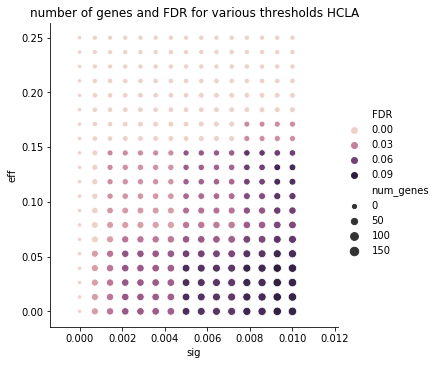

In [32]:
sns.relplot(x="sig",y="eff",hue="FDR",size="num_genes",data=out_df)
plt.title("number of genes and FDR for various thresholds HCLA")
plt.show()

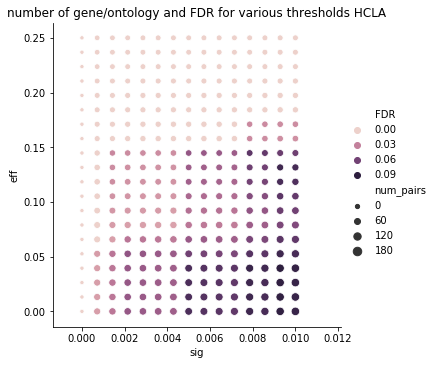

In [33]:
sns.relplot(x="sig",y="eff",hue="FDR",size="num_pairs",data=out_df)
plt.title("number of gene/ontology and FDR for various thresholds HCLA")

plt.show()

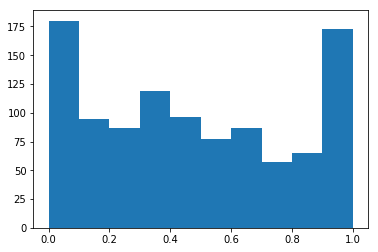

In [88]:
plt.hist(df1[df1["ontology"] == "lungimmuneMacrophage"]["allp"])
plt.show()

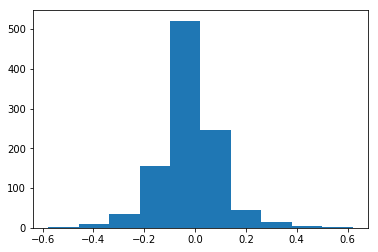

In [89]:
plt.hist(df1[df1["ontology"] == "lungimmuneMacrophage"]["mz"])
plt.show()